# Overview:

This implementation relies on the following python packages
- numpy
- matplotlib
- scipy
*Specifically* requires one to use `scipy.integrate.solve_ivp`, and `matplotlib.pyplot`

## General Structure
This code is structured with the following functions
```python
+ Helper Functions
    + alpha_h(V)
    + alpha_n(V)
    + alpha_m(V)
    + beta_h(V)
    + beta_n(V)
    + beta_m(V)
    + m_inf(V)
    + n_inf(V)
    + h_inf(V)
+ hh_cable_ode(t, y, N, G_axial, g_Na_total, g_K_total, g_L_total, C, inject_current, inject_current_when=[0, 20])
+ simulate_and_plot(N_values, step_size=0.1)

Called like `simulate_and_plot([10, 100, 1000])`

simulate_and_plot has a for loop that goes through the N_values and calls hh_cable_ode with the given N value. It then plots the results of the simulation.
```

Leonardo Ferrisi

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [3]:
# Givens
v_k  =  -77   # mV
v_na =  50    # mV
v_L  = -54.4  # mV
current_injection_nA = 169e-9 # nA

# All lengths are now in microns (um)
axon_length_um = 10000      # 1 cm = 10,000 um
radius_um      = 100        # um
R_i            = 10**6      # intracellular resistivity in ohm/um^2

# Adjust membrane properties:
C_m  = 10   * 1e-15  # F/um²
g_Na_max = 1200 * 1e-12  # S/um²
g_K_max  =  360 * 1e-12  # S/um²
g_L_max  =    3 * 1e-12  # S/um²

In [4]:
# Helper Functions

def alpha_h(V):
    __ah =  .07 * np.exp(-(V+65)/20)
    return __ah

def alpha_n(V):
    __an = .01 * (V+55) / (1 - np.exp(-(V+55)/10))
    if np.isnan(__an): __an = 0.1
    return __an

def alpha_m(V):
    __am = .1 * (V+40) / (1 - np.exp(-(V+40)/10))
    if np.isnan(__am): __am = 1.0
    return __am

def beta_h(V):
    return 1 / (1 + np.exp(-(V+35)/10))

def beta_n(V):
    return .125 * np.exp(-(V+65)/80)

def beta_m(V):
    return 4 * np.exp(-(V+65)/18)

# Steady-state gating variables (with V in mV)
def m_inf(V):
    a = alpha_m(V)
    b = beta_m(V)
    return a / (a + b)

def h_inf(V):
    a = alpha_h(V)
    b = beta_h(V)
    return a / (a + b)

def n_inf(V):
    a = alpha_n(V)
    b = beta_n(V)
    return a / (a + b)

In [5]:
# --- ODE Function for HH Cable Model ---
# Here:
# - Voltage V is in mV,
# - Time t is in ms.
# - Reversal potentials are specified in mV.
# - When computing currents, voltage differences are converted from mV to V (dividing by 1000)
#   so that the SI units of conductance (S) work correctly.
# - dV/dt = (I_total)/C gives a result in V/s; numerically 1 V/s = 1 mV/ms.
def hh_cable_ode(t, y, N, G_axial, g_Na_total, g_K_total, g_L_total, C, inject_current, inject_current_when=[0, 20]):
    """
    Models a Hodgkin-Huxley cable with N compartments.

    Parameters:
    - t: time (ms)
    - y: state vector (array of length 4*N)
        - An example statevector for N=2 will look like: `y = [V1, m1, h1, n1, V2, m2, h2, n2]`
    - N: number of compartments
    - G_axial: axial conductance (S)
    - g_Na_total: total Na conductance (S)
    - g_K_total: total K conductance (S)
    - g_L_total: total leak conductance (S)
    - C: membrane capacitance (F)
    - inject_current: whether to inject current in the first compartment for t < 20 ms
    - inject_current_when: time interval for injecting current (ms)
    """
    dydt = np.zeros_like(y)
    for i in range(N):
        idx = 4 * i  # compartment i's state is at indices 4*i to 4*i+3
        V = y[idx]   # in mV
        m = y[idx + 1]
        h = y[idx + 2]
        n = y[idx + 3]
        
        # Gating variable derivatives (rates in 1/ms)
        dmdt = alpha_m(V) * (1 - m) - beta_m(V) * m
        dhdt = alpha_h(V) * (1 - h) - beta_h(V) * h
        dndt = alpha_n(V) * (1 - n) - beta_n(V) * n
        
        dydt[idx + 1] = dmdt
        dydt[idx + 2] = dhdt
        dydt[idx + 3] = dndt
        
        # Ionic currents:
        # Convert voltage differences from mV to V by dividing by 1000.
        #   - This is necessary to ensure that the SI units of conductance (S) work correctly.
        #   - V * S = I
        I_Na = g_Na_total * (m**3) * h * ((V - v_na) / 1000) # I_Na (A)  
        I_K  = g_K_total * (n**4) * ((V - v_k) / 1000)       # I_K (A)
        I_L  = g_L_total * ((V - v_L) / 1000)                # I_L (A)
        I_ion = I_Na + I_K + I_L

        # Axial current:
        I_axial = 0.0
        if N > 1:
            if i == 0: # If at end
                left_compartment_voltage = y[4*(i+1)]
                I_axial = G_axial * ((left_compartment_voltage - V) / 1000) # In A
            elif i == N-1: # If at beginning
                right_compartment_voltage = y[4*(i-1)]
                I_axial = G_axial * ((right_compartment_voltage - V) / 1000)# In A
            else:
                left_compartment_voltage = y[4*(i+1)]
                right_compartment_voltage = y[4*(i-1)]
                V_axial = (right_compartment_voltage - V) + (left_compartment_voltage - V)
                I_axial = G_axial * (V_axial / 1000) # In f
        
        # Injected current (only in first compartment for t < 20 ms)
        I_inj = 0.0

        if inject_current:
            t_start, t_end = inject_current_when
            if i == 0 and t >= t_start and t < t_end:
                I_inj = 169e-9 # 169e-9 A = 169 nA
        
        # dV/dt:
        # (I_axial + I_inj - I_ion) / C gives a derivative in V/s.
        # Since 1 V/s numerically equals 1 mV/ms, we treat dV/dt as mV/ms.
        dVdt = (I_axial + I_inj - I_ion) / C  
        dydt[idx] = dVdt
        
        # print(f"This has been run {i} times")
    return dydt


In [6]:
# --- Simulation and Plotting ---
def simulate_and_plot(N_values, step_size=0.1):
    """
    Use solve_ivp to simulate and plot charts for each of the N_values provided

    Parameters:
    - N_values: list of compartment numbers
    - step_size: time step size for the simulation

    """
    plt.figure(figsize=(15, 10))
    
    for plot_idx, N in enumerate(N_values, 1):
        # Compartment length in um:
        L_comp_um = axon_length_um / N
        
        # Lateral surface area of a cylindrical compartment (um²)
        surface_area_um2 = 2 * np.pi * radius_um * L_comp_um
        
        # Total capacitance and conductances for the compartment:
        C = C_m * surface_area_um2         # in Farads
        g_Na_total = g_Na_max * surface_area_um2  # in Siemens
        g_K_total  = g_K_max  * surface_area_um2  # in Siemens
        g_L_total  = g_L_max  * surface_area_um2  # in Siemens
        
        # Axial resistance (ohms) computed from length in um and cross-sectional area in um².
        R_axial = (R_i * L_comp_um) / (np.pi * (radius_um)**2)
        G_axial = 1 / R_axial  # Siemens
        
        # Initial conditions: Voltage is in mV.
        V_rest = -65  # mV
        y0 = []
        for _ in range(N):
            m0 = m_inf(V_rest)
            h0 = h_inf(V_rest)
            n0 = n_inf(V_rest)
            y0.extend([V_rest, m0, h0, n0])
        y0 = np.array(y0)
        
        sol = solve_ivp(
            fun=lambda t, y: hh_cable_ode(t, y, N, G_axial, g_Na_total, g_K_total, g_L_total, C, True),
            t_span=(0, 50),  # time in ms
            y0=y0,
            method='BDF', # BDF seems to be faster than RK45
            rtol=1e-6,
            atol=1e-6,
            max_step=step_size
        )
        
        plt.subplot(2, 2, plot_idx)
        time_ms = sol.t  # already in ms
        for i in range(N):
            V_idx = 4 * i
            V_trace = sol.y[V_idx]
            plt.plot(time_ms, V_trace, label=f'Comp {i+1}')
        plt.title(f'{N} Compartments')
        plt.xlabel('Time (ms)')
        plt.ylabel('Membrane Potential (mV)')
        # plt.legend()
        print(f'Finished simulation for {N} compartments')
    
    plt.tight_layout()
    plt.show()

Finished simulation for 3 compartments
Finished simulation for 10 compartments
Finished simulation for 30 compartments
Finished simulation for 100 compartments


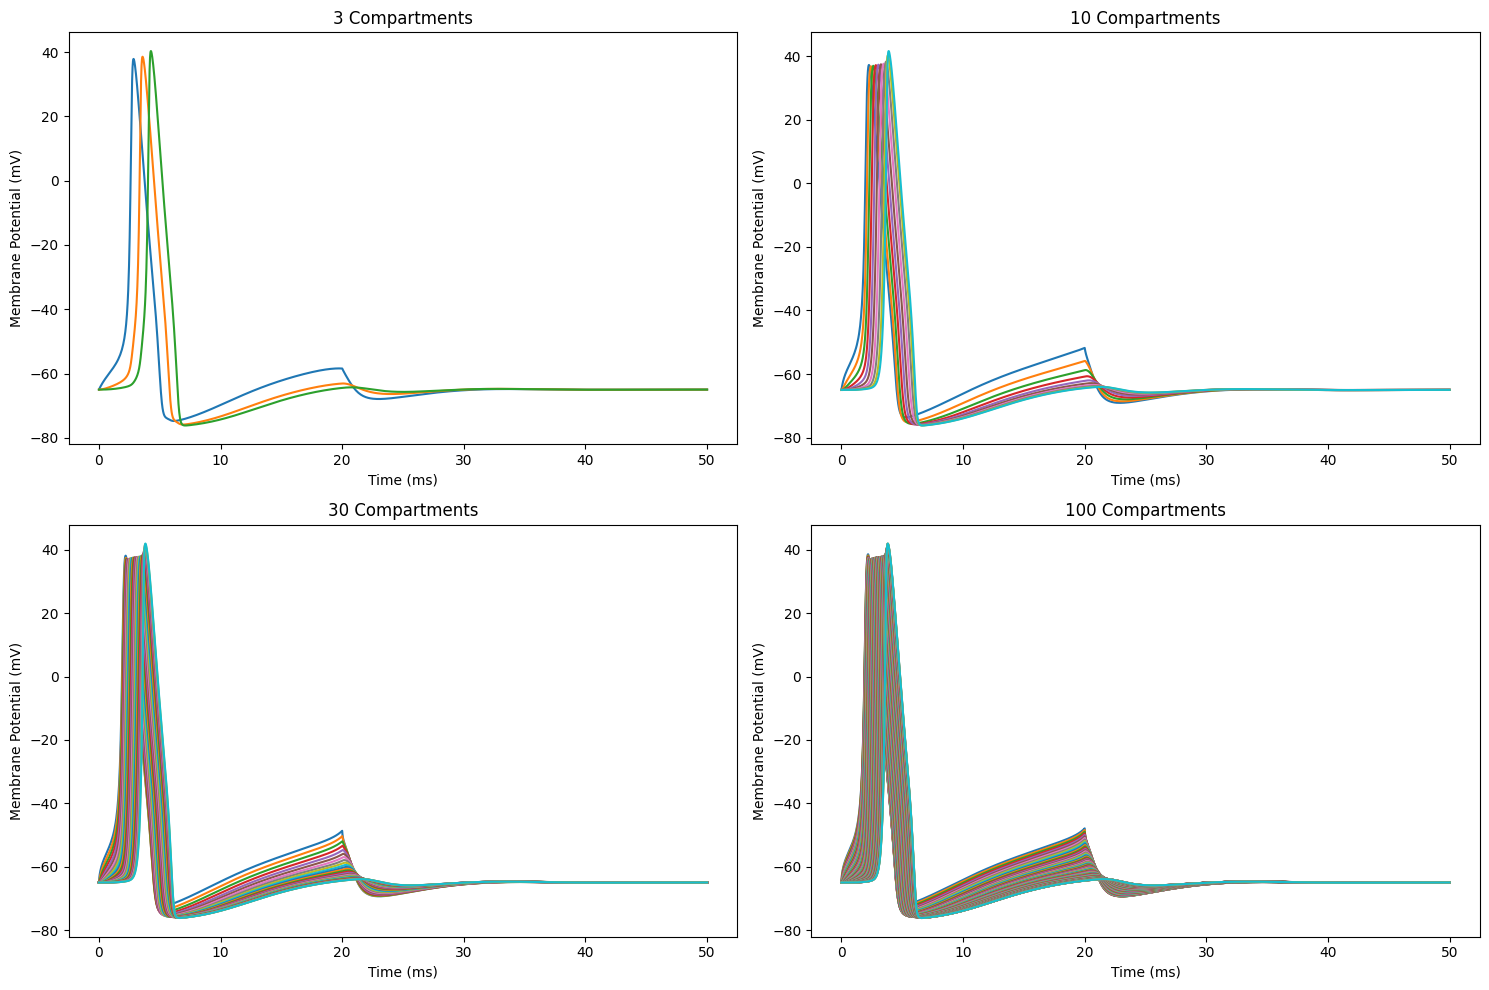

In [7]:
# Run the simulation for a set of compartment numbers (e.g., 3 compartments)
simulate_and_plot([3, 10, 30, 100], step_size=0.1)
